#Machine Learning TP2 - EFREI M1


Team Members : Maxime Alves (2020090), Alix Brunet (20211029), Kevin Truong (20210400)

# Part 1: EDA, Clustering and Dimensionality reduction

## Imports


In [5]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Exercise 1: Exploratory Data Analysis (EDA)

1. Load the dataset using pandas


In [6]:
data = fetch_openml(data_id=43582, as_frame=True)
df = data.frame

# Drop the target column "Outcome" since we are doing unsupervised learning
df = df.drop(columns=["Outcome"])

2. Display basic statistics (describe()) for all features

In [7]:
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age  
count  768.000000                768.000000  768.000000  
mean    31.992578                  0.471876   33.240885  
std      7.884160                  0.331329   11.760232  
min      0.000000                  0.078000   21.000000  
25%    

3. Visualize the data distribution of each feature (histograms)

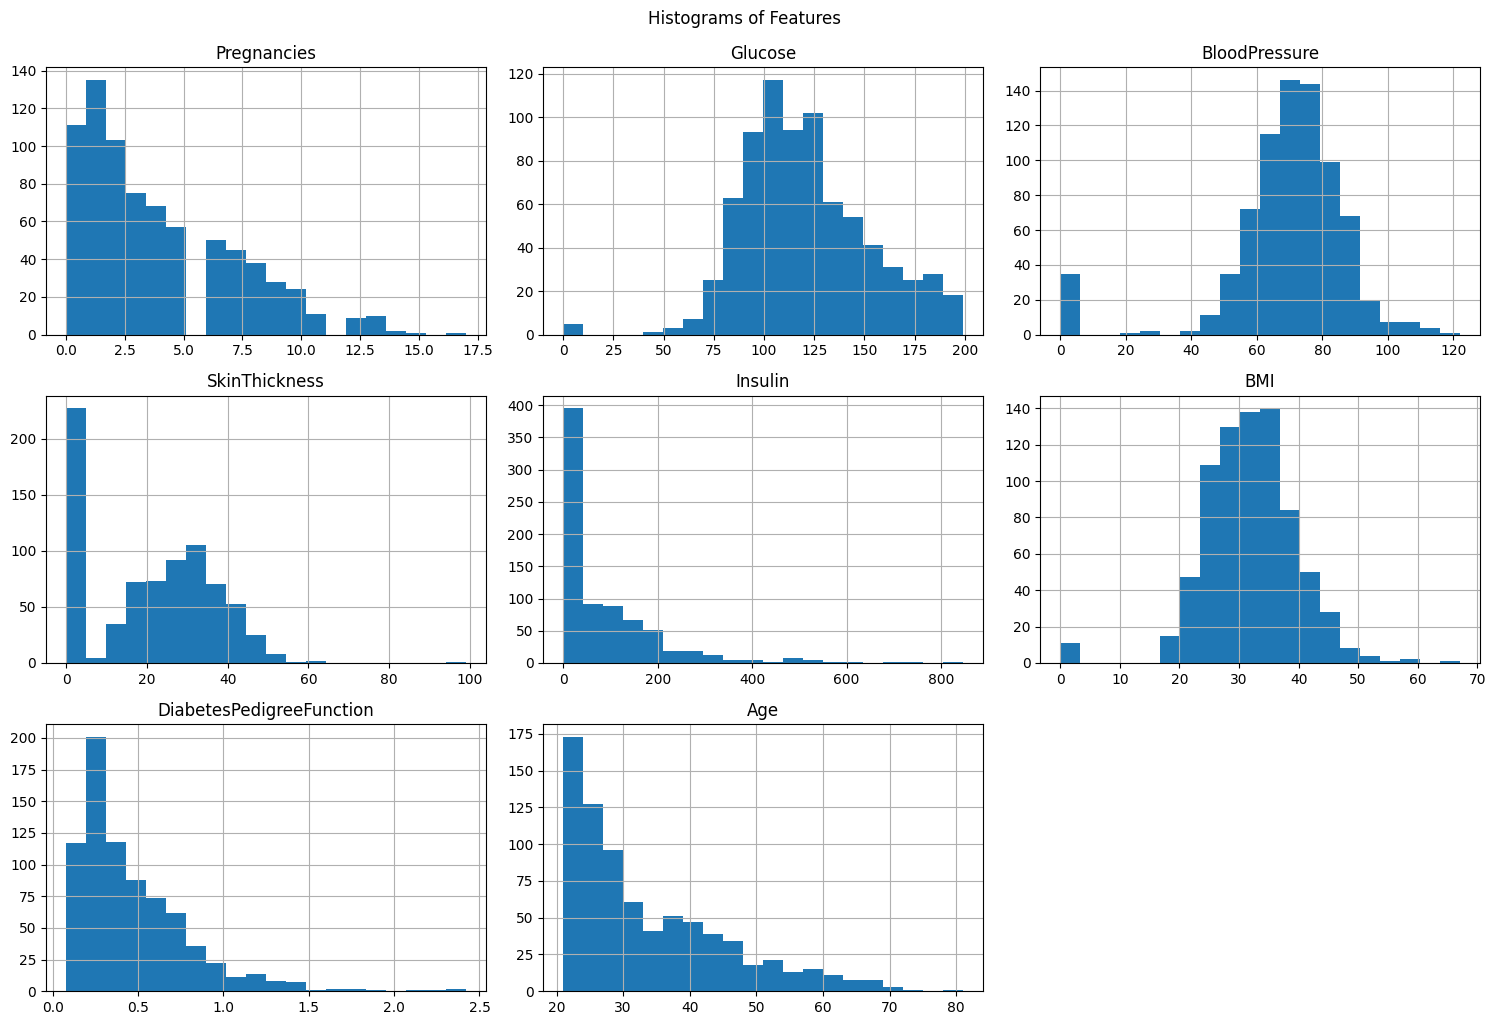

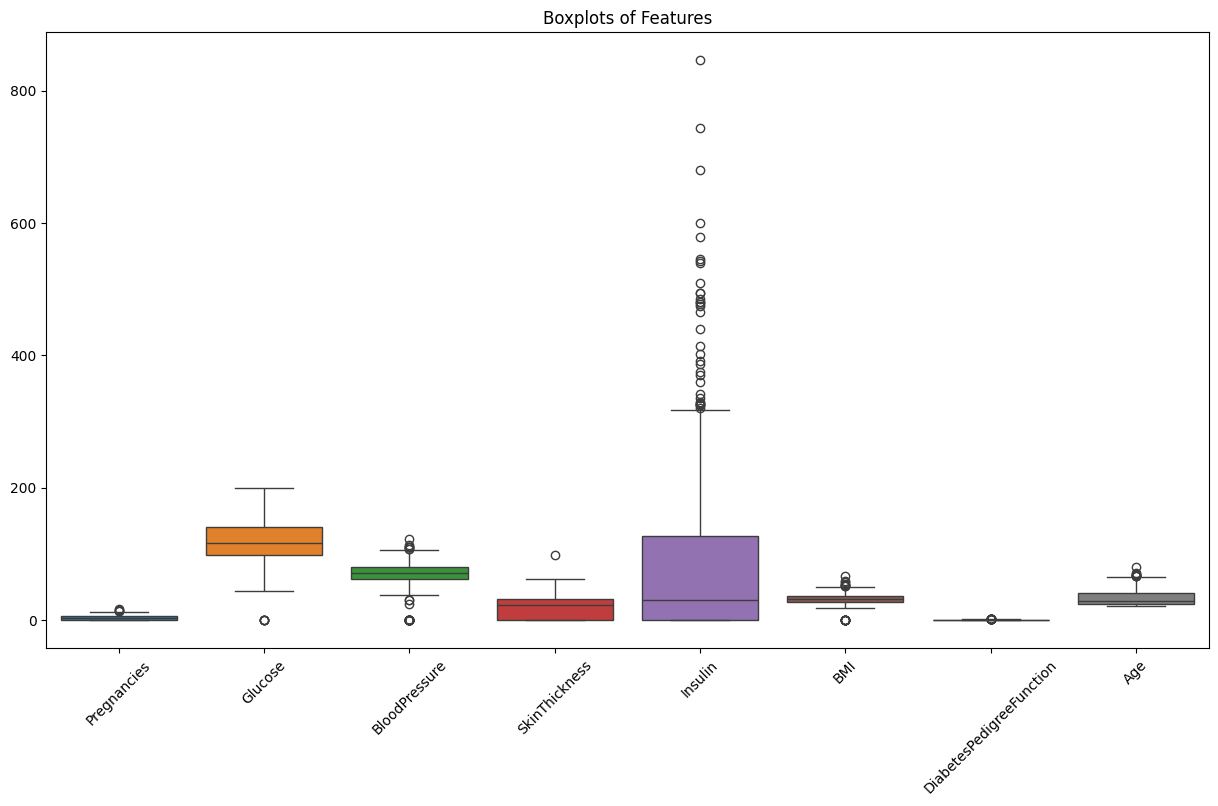

In [8]:
df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.suptitle("Histograms of Features", y=1.02)
plt.show()

# Boxplots for each feature

plt.figure(figsize=(15, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplots of Features")
plt.show()

4. Check for missing data or anomalous zeros

In [9]:
zero_counts = (df == 0).sum()
zero_percent = 100 * zero_counts / len(df)
print("Percentage of zero values per column:\n", zero_percent)
print("Columns where zero values are potentially invalid")
columns_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in columns_with_zeros:
    print(f"\t{col} - zero values: {(df[col] == 0).sum()}")

Percentage of zero values per column:
 Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
dtype: float64
Columns where zero values are potentially invalid
	Glucose - zero values: 5
	BloodPressure - zero values: 35
	SkinThickness - zero values: 227
	Insulin - zero values: 374
	BMI - zero values: 11


5. Identify potential outliers using boxplots (IQR method)

In [10]:
# Create a dictionary to store outlier counts
outlier_counts = {}

# Loop through each column and compute outliers
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# Print outlier counts per feature
print("Number of outliers per feature (IQR method):")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

Number of outliers per feature (IQR method):
Pregnancies: 4 outliers
Glucose: 5 outliers
BloodPressure: 45 outliers
SkinThickness: 1 outliers
Insulin: 34 outliers
BMI: 19 outliers
DiabetesPedigreeFunction: 29 outliers
Age: 9 outliers


6. Standardize the data using StandardScaler

In [11]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Display statistics after scaling
print("Scaled Data Statistics:")
print(df_scaled.describe())

Scaled Data Statistics:
        Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
count  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02  7.680000e+02   
mean  -6.476301e-17 -9.251859e-18   1.503427e-17   1.006140e-16 -3.006854e-17   
std    1.000652e+00  1.000652e+00   1.000652e+00   1.000652e+00  1.000652e+00   
min   -1.141852e+00 -3.783654e+00  -3.572597e+00  -1.288212e+00 -6.928906e-01   
25%   -8.448851e-01 -6.852363e-01  -3.673367e-01  -1.288212e+00 -6.928906e-01   
50%   -2.509521e-01 -1.218877e-01   1.496408e-01   1.545332e-01 -4.280622e-01   
75%    6.399473e-01  6.057709e-01   5.632228e-01   7.190857e-01  4.120079e-01   
max    3.906578e+00  2.444478e+00   2.734528e+00   4.921866e+00  6.652839e+00   

                BMI  DiabetesPedigreeFunction           Age  
count  7.680000e+02              7.680000e+02  7.680000e+02  
mean   2.590520e-16              2.174187e-16  1.931325e-16  
std    1.000652e+00              1.000652e+00  1.000652e+00 

Exercise 2: K-Means Clustering

1. Apply K-Means clustering (with k=2) to the standardized data

In [12]:
# Set number of clusters to 2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_scaled)

# Get cluster labels
labels = kmeans.labels_

# Add labels to a copy of the original dataframe
df_with_labels = df.copy()
df_with_labels["Cluster"] = labels


2. Visualize the resulting clusters using a scatter plot (select two features)

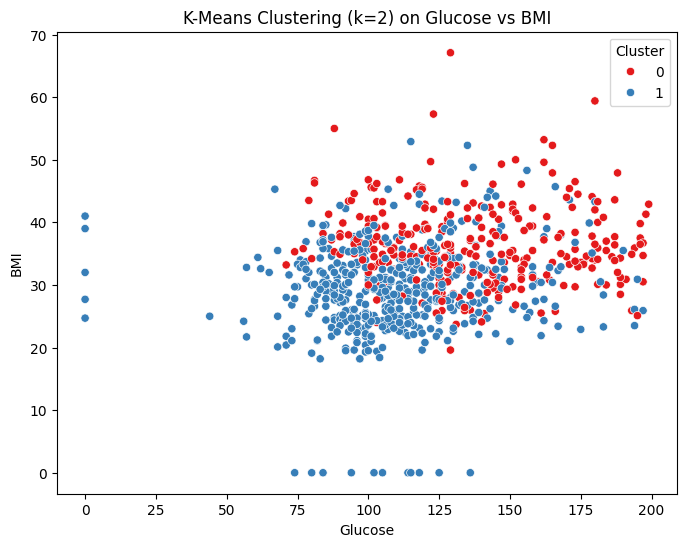

In [13]:
# Choose two features for visualization
feature_x = "Glucose"
feature_y = "BMI"

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_with_labels, x=feature_x, y=feature_y, hue="Cluster", palette="Set1"
)
plt.title(f"K-Means Clustering (k=2) on {feature_x} vs {feature_y}")
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title="Cluster")
plt.show()


3. Interpret the results (do the clusters make sense?).

By applying K-means with k = 2, 2 clusters are visible. The red one includes individuals with high glucose and BMI values. The blue cluster includes individuals with generally lower levels of both features. The glucose axis is the clearest separation. Some overlap persists, especially around intermediate values.

Exercise 3: PCA and Visualization

1. Apply PCA to reduce the dataset to 2 components

In [14]:
# Apply PCA to standardized data
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

# Convert to DataFrame for plotting
df_pca = pd.DataFrame(data=pca_components, columns=["PC1", "PC2"])
df_pca["Cluster"] = labels  # defined in ex2

2. Display the explained variance ratio for each principal component

In [15]:
# 2. Display the explained variance ratio for each principal component
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

Explained variance ratio:
[0.26179749 0.21640127]


3. Plot the data points using the first 2 principal components

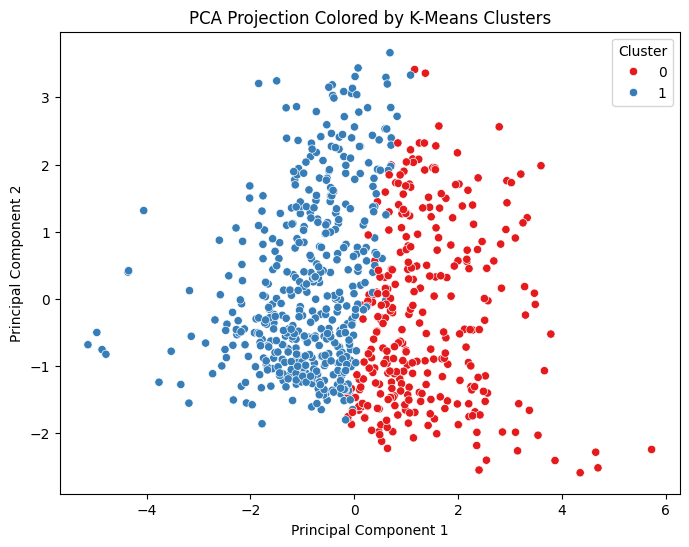

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="Set1")
plt.title("PCA Projection Colored by K-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

4. Which features contribute most to PC1 and PC2?


*   PC1 : Glucose, Age and BMI
*   PC2 : DiabetesPedigreeFunction, Insulin and SkinThickness



5. Inspect the PCA loadings (components)

In [17]:
pca_loadings = pd.DataFrame(pca.components_, columns=df.columns, index=["PC1", "PC2"])
print("PCA Loadings (Component Weights):")
print(pca_loadings)

# To see the top contributing features
print("\nTop contributing features to PC1:")
print(pca_loadings.loc["PC1"].abs().sort_values(ascending=False))

print("\nTop contributing features to PC2:")
print(pca_loadings.loc["PC2"].abs().sort_values(ascending=False))

PCA Loadings (Component Weights):
     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
PC1     0.128432  0.393083       0.360003       0.439824  0.435026  0.451941   
PC2     0.593786  0.174029       0.183892      -0.331965 -0.250781 -0.100960   

     DiabetesPedigreeFunction       Age  
PC1                  0.270611  0.198027  
PC2                 -0.122069  0.620589  

Top contributing features to PC1:
BMI                         0.451941
SkinThickness               0.439824
Insulin                     0.435026
Glucose                     0.393083
BloodPressure               0.360003
DiabetesPedigreeFunction    0.270611
Age                         0.198027
Pregnancies                 0.128432
Name: PC1, dtype: float64

Top contributing features to PC2:
Age                         0.620589
Pregnancies                 0.593786
SkinThickness               0.331965
Insulin                     0.250781
BloodPressure               0.183892
Glucose               

Exercise 4 : K-Means on PCA-transformed data

1. Apply K-Means clustering on PCA-transformed data (2D)

In [18]:
kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_pca.fit(df_pca[["PC1", "PC2"]])

# Get the new cluster labels
pca_labels = kmeans_pca.labels_

# Add to the PCA DataFrame
df_pca["PCA_Cluster"] = pca_labels

2. Compare clusters obtained in Exercise 2 vs. this one (on PCA-reduced data)

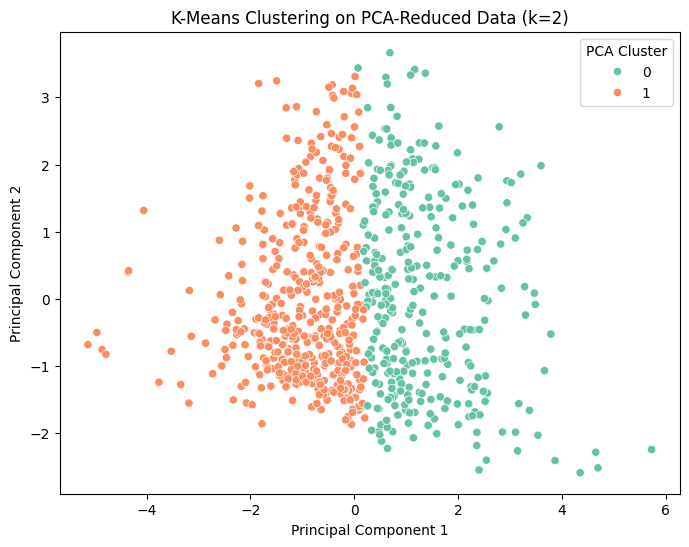

In [19]:
# Plot with PCA-based clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="PCA_Cluster", palette="Set2")
plt.title("K-Means Clustering on PCA-Reduced Data (k=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="PCA Cluster")
plt.show()

3. Discuss the advantages or drawbacks of clustering in the original space vs. PCA space.

In the PCA-transformed space, the two clusters are much more distinctly separated, particularly along the first principal component. The decision boundary appears almost perfectly vertical and linear, indicating that this component captures the most critical variance needed to distinguish between the groups.

By contrast, in the original space, the clusters overlapped more and were less clearly defined. This is likely due to the use of all eight original dimensions.

# Discussion

When does PCA help clustering?


PCA helps clustering when the original dataset includes some features like redundant or highly correlated features, noisy variables, high-dimensional spaces. In this case of dataset, applying PCA helped reveal more distinct clusters by projecting the data into a 2D space.

How did scaling impact the results?


Scaling impacts the results by ensuring that all features contribute equally to the analysis. Without scaling, variables like Glucose could dominate both the PCA directions and the K-Means clustering process. Thanks to StandardScaler, the data was standardized.

Are clusters meaningful in this context? How could you improve them?


The clusters are meaningful in this context but not perfect because some overlap exists between groups. We could improve them by applying different clustering algorithms. For example: Gaussian Mixture Models.

# Part 2: Text classification using Bag of Words, TF-IDF, Word2Vec and BERT embeddings.

Exercise 1: Text Preprocessing


In [23]:
# Imports for Part 2
import numpy as np
import re
import spacy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from transformers import BertTokenizer, BertModel
import torch
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

# Load spacy model for lemmatization
# Run: python -m spacy download en_core_web_sm if not installed
nlp = spacy.load("en_core_web_sm")

In [24]:
# 1. Load dataset using fetch_20newsgroups()
# Filter for the 5 computing categories
categories = [
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
]

# Load the dataset
newsgroups_train = fetch_20newsgroups(
    subset="train", categories=categories, remove=("headers", "footers", "quotes")
)
newsgroups_test = fetch_20newsgroups(
    subset="test", categories=categories, remove=("headers", "footers", "quotes")
)

print(f"Training samples: {len(newsgroups_train.data)}")
print(f"Test samples: {len(newsgroups_test.data)}")
print(f"Categories: {newsgroups_train.target_names}")

Training samples: 2936
Test samples: 1955
Categories: ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x']


In [25]:
# 3. Preprocess function
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(r"[^\w\s]", " ", text)

    # Remove extra whitespaces
    text = " ".join(text.split())

    # Lemmatize using spaCy
    doc = nlp(text)
    lemmatized = " ".join(
        [
            token.lemma_
            for token in doc
            if not token.is_stop and not token.is_punct and len(token.text) > 2
        ]
    )

    return lemmatized


# Apply preprocessing to all texts
print("Preprocessing training data...")
X_train_processed = [preprocess_text(text) for text in newsgroups_train.data]
y_train = newsgroups_train.target

print("Preprocessing test data...")
X_test_processed = [preprocess_text(text) for text in newsgroups_test.data]
y_test = newsgroups_test.target

print(f"Sample processed text: {X_train_processed[0][:200]}...")

Preprocessing training data...
Preprocessing test data...
Sample processed text: remember read hallucinating ncd xremote functionality give ncd mit inclusion x11r6 true set mode cheap wait x11r6 compress serial line server support thank...


Exercise 2 Bag of Words (BoW)

In [26]:
# 1. Vectorize using CountVectorizer (remove stopwords)
vectorizer_bow = CountVectorizer(stop_words="english", max_features=10000)
X_train_bow = vectorizer_bow.fit_transform(X_train_processed)
X_test_bow = vectorizer_bow.transform(X_test_processed)

# 2. Visualize vocabulary size
print(f"Vocabulary size: {len(vectorizer_bow.vocabulary_)}")
print(f"Training matrix shape: {X_train_bow.shape}")
print(f"Test matrix shape: {X_test_bow.shape}")

Vocabulary size: 10000
Training matrix shape: (2936, 10000)
Test matrix shape: (1955, 10000)


In [27]:
# 3. Train model (MultinomialNB)
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)

# 4. Evaluate accuracy
y_pred_bow = nb_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, y_pred_bow)

print(f"\nBag of Words - Naive Bayes Accuracy: {accuracy_bow:.4f}")
print("\nClassification Report:")
print(
    classification_report(y_test, y_pred_bow, target_names=newsgroups_test.target_names)
)


Bag of Words - Naive Bayes Accuracy: 0.6118

Classification Report:
                          precision    recall  f1-score   support

           comp.graphics       0.61      0.77      0.68       389
 comp.os.ms-windows.misc       0.94      0.04      0.07       394
comp.sys.ibm.pc.hardware       0.57      0.71      0.63       392
   comp.sys.mac.hardware       0.61      0.79      0.69       385
          comp.windows.x       0.65      0.76      0.70       395

                accuracy                           0.61      1955
               macro avg       0.68      0.61      0.55      1955
            weighted avg       0.68      0.61      0.55      1955



Exercise 3 TF-IDF

In [28]:
# 1. Vectorize with TfidfVectorizer (remove stopwords)
vectorizer_tfidf = TfidfVectorizer(stop_words="english", max_features=10000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_processed)
X_test_tfidf = vectorizer_tfidf.transform(X_test_processed)

# 2. Compare average TF-IDF values for top 10 terms
feature_names = vectorizer_tfidf.get_feature_names_out()
mean_tfidf = X_train_tfidf.mean(axis=0).A1
top_indices = mean_tfidf.argsort()[-10:][::-1]

print("Top 10 terms by average TF-IDF score:")
for idx in top_indices:
    print(f"{feature_names[idx]}: {mean_tfidf[idx]:.4f}")

Top 10 terms by average TF-IDF score:
window: 0.0263
file: 0.0217
thank: 0.0211
know: 0.0209
use: 0.0199
problem: 0.0194
drive: 0.0194
card: 0.0183
work: 0.0167
like: 0.0167


In [29]:
# 3. Train same model as Exercise 2
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

# 4. Evaluate accuracy
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

print(f"\nTF-IDF - Naive Bayes Accuracy: {accuracy_tfidf:.4f}")
print("\nClassification Report:")
print(
    classification_report(
        y_test, y_pred_tfidf, target_names=newsgroups_test.target_names
    )
)

print(f"\n**Question**: How does TF-IDF improve BoW?")
print(f"TF-IDF accuracy ({accuracy_tfidf:.4f}) vs BoW accuracy ({accuracy_bow:.4f})")
print(
    f"Improvement: {((accuracy_tfidf - accuracy_bow) / accuracy_bow * 100):.2f}%"
    if accuracy_tfidf > accuracy_bow
    else "TF-IDF performs worse than BoW"
)


TF-IDF - Naive Bayes Accuracy: 0.7120

Classification Report:
                          precision    recall  f1-score   support

           comp.graphics       0.72      0.72      0.72       389
 comp.os.ms-windows.misc       0.72      0.56      0.63       394
comp.sys.ibm.pc.hardware       0.68      0.72      0.70       392
   comp.sys.mac.hardware       0.72      0.75      0.73       385
          comp.windows.x       0.72      0.80      0.75       395

                accuracy                           0.71      1955
               macro avg       0.71      0.71      0.71      1955
            weighted avg       0.71      0.71      0.71      1955


**Question**: How does TF-IDF improve BoW?
TF-IDF accuracy (0.7120) vs BoW accuracy (0.6118)
Improvement: 16.39%


**Question**: How does TF-IDF improve BoW?

TF-IDF improves upon BoW by weighting terms based on their importance. While BoW only counts term frequency, TF-IDF considers both term frequency (TF) and inverse document frequency (IDF). This means that common words that appear in many documents get lower weights, while rare but informative words get higher weights, leading to better text representation and classification performance.

Exercise 4 Word2Vec

In [30]:
# 1. Vectorize with Gensim Word2Vec
# Prepare sentences for Word2Vec (list of words)
train_sentences = [text.split() for text in X_train_processed]
test_sentences = [text.split() for text in X_test_processed]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=train_sentences, vector_size=100, window=5, min_count=2, workers=4, sg=0
)
print(f"Word2Vec vocabulary size: {len(w2v_model.wv.key_to_index)}")

Word2Vec vocabulary size: 15522


In [31]:
# 2. Represent document = average of embeddings
def get_doc_vector(doc, model):
    """Get document vector by averaging word vectors"""
    vectors = []
    for word in doc:
        if word in model.wv.key_to_index:
            vectors.append(model.wv[word])

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


# Create document vectors
X_train_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in train_sentences])
X_test_w2v = np.array([get_doc_vector(doc, w2v_model) for doc in test_sentences])

print(f"Training matrix shape: {X_train_w2v.shape}")
print(f"Test matrix shape: {X_test_w2v.shape}")

Training matrix shape: (2936, 100)
Test matrix shape: (1955, 100)


In [32]:
# 3. Train (GaussianNB)
nb_w2v = GaussianNB()
nb_w2v.fit(X_train_w2v, y_train)

# 4. Evaluate accuracy
y_pred_w2v = nb_w2v.predict(X_test_w2v)
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)

print(f"\nWord2Vec - Gaussian Naive Bayes Accuracy: {accuracy_w2v:.4f}")
print("\nClassification Report:")
print(
    classification_report(y_test, y_pred_w2v, target_names=newsgroups_test.target_names)
)

print(f"\n**Question**: Compare to BoW and TF-IDF. Key differences?")
print(f"Word2Vec accuracy: {accuracy_w2v:.4f}")
print(f"TF-IDF accuracy: {accuracy_tfidf:.4f}")
print(f"BoW accuracy: {accuracy_bow:.4f}")


Word2Vec - Gaussian Naive Bayes Accuracy: 0.3923

Classification Report:
                          precision    recall  f1-score   support

           comp.graphics       0.40      0.18      0.25       389
 comp.os.ms-windows.misc       0.22      0.11      0.15       394
comp.sys.ibm.pc.hardware       0.43      0.47      0.45       392
   comp.sys.mac.hardware       0.42      0.43      0.43       385
          comp.windows.x       0.40      0.76      0.53       395

                accuracy                           0.39      1955
               macro avg       0.37      0.39      0.36      1955
            weighted avg       0.37      0.39      0.36      1955


**Question**: Compare to BoW and TF-IDF. Key differences?
Word2Vec accuracy: 0.3923
TF-IDF accuracy: 0.7120
BoW accuracy: 0.6118


**Question**: Compare to BoW and TF-IDF. Key differences?

Word2Vec captures semantic relationships between words by learning dense vector representations, unlike BoW and TF-IDF which use sparse representations. Word2Vec can understand that similar words have similar meanings, but it requires averaging word vectors to create document representations, which can lose some information. The performance depends on the quality of word embeddings and the averaging strategy used.

Exercise 5 Doc2Vec

In [33]:
# 1. Vectorize using Gensim Doc2Vec
# Prepare tagged documents for Doc2Vec
train_tagged = [
    TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(train_sentences)
]
test_tagged = [
    TaggedDocument(words=doc, tags=[str(i + len(train_sentences))])
    for i, doc in enumerate(test_sentences)
]

# Train Doc2Vec model
d2v_model = Doc2Vec(
    train_tagged, vector_size=100, window=5, min_count=2, workers=4, epochs=20
)
print(f"Doc2Vec model trained with {len(train_tagged)} documents")

Doc2Vec model trained with 2936 documents


In [34]:
# Get document vectors
X_train_d2v = np.array([d2v_model.dv[str(i)] for i in range(len(train_sentences))])
X_test_d2v = np.array([d2v_model.infer_vector(doc) for doc in test_sentences])

print(f"Training matrix shape: {X_train_d2v.shape}")
print(f"Test matrix shape: {X_test_d2v.shape}")

Training matrix shape: (2936, 100)
Test matrix shape: (1955, 100)


In [35]:
# 2. Train (GaussianNB)
nb_d2v = GaussianNB()
nb_d2v.fit(X_train_d2v, y_train)

# 3. Evaluate accuracy
y_pred_d2v = nb_d2v.predict(X_test_d2v)
accuracy_d2v = accuracy_score(y_test, y_pred_d2v)

print(f"\nDoc2Vec - Gaussian Naive Bayes Accuracy: {accuracy_d2v:.4f}")
print("\nClassification Report:")
print(
    classification_report(y_test, y_pred_d2v, target_names=newsgroups_test.target_names)
)

print(f"\n**Question**: Comparison to previous models?")
print(f"Doc2Vec accuracy: {accuracy_d2v:.4f}")
print(f"Word2Vec accuracy: {accuracy_w2v:.4f}")
print(f"TF-IDF accuracy: {accuracy_tfidf:.4f}")
print(f"BoW accuracy: {accuracy_bow:.4f}")


Doc2Vec - Gaussian Naive Bayes Accuracy: 0.2829

Classification Report:
                          precision    recall  f1-score   support

           comp.graphics       0.34      0.27      0.30       389
 comp.os.ms-windows.misc       0.13      0.06      0.08       394
comp.sys.ibm.pc.hardware       0.34      0.26      0.30       392
   comp.sys.mac.hardware       0.24      0.62      0.35       385
          comp.windows.x       0.47      0.21      0.29       395

                accuracy                           0.28      1955
               macro avg       0.31      0.28      0.26      1955
            weighted avg       0.31      0.28      0.26      1955


**Question**: Comparison to previous models?
Doc2Vec accuracy: 0.2829
Word2Vec accuracy: 0.3923
TF-IDF accuracy: 0.7120
BoW accuracy: 0.6118


**Question**: Comparison to previous models?

Doc2Vec creates direct document-level embeddings rather than averaging word vectors like Word2Vec. This allows it to capture document-specific context and structure better than Word2Vec averaging. Doc2Vec can learn unique representations for each document while still capturing semantic relationships, potentially leading to better performance than simple word vector averaging.

Exercise 6 BERT Embeddings

In [36]:
# 1. Use Hugging Face Transformers - Pretrained BERT
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"Using device: {device}")
print("BERT model loaded successfully")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cpu
BERT model loaded successfully


In [37]:
def get_bert_embeddings(texts, tokenizer, model, max_length=512, batch_size=8):
    """Get BERT embeddings with mean pooling of token embeddings"""
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]

        # Tokenize
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )

        # Move to device
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        # Get embeddings
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Mean pooling of token embeddings
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        )
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask

        embeddings.extend(mean_embeddings.cpu().numpy())

        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {min(i + batch_size, len(texts))}/{len(texts)} texts")

    return np.array(embeddings)


print("BERT embedding function defined")

BERT embedding function defined


In [38]:
# Generate BERT embeddings (this may take some time)
print("Generating BERT embeddings for training data...")
X_train_bert = get_bert_embeddings(
    X_train_processed[:500], tokenizer, model
)  # Limit for speed
y_train_bert = y_train[:500]

print("Generating BERT embeddings for test data...")
X_test_bert = get_bert_embeddings(
    X_test_processed[:200], tokenizer, model
)  # Limit for speed
y_test_bert = y_test[:200]

print(f"Training matrix shape: {X_train_bert.shape}")
print(f"Test matrix shape: {X_test_bert.shape}")

Generating BERT embeddings for training data...
Processed 80/500 texts
Processed 160/500 texts
Processed 240/500 texts
Processed 320/500 texts
Processed 400/500 texts
Processed 480/500 texts
Generating BERT embeddings for test data...
Processed 80/200 texts
Processed 160/200 texts
Training matrix shape: (500, 768)
Test matrix shape: (200, 768)


In [39]:
# 2. Train (Logistic Regression - better for high-dimensional dense features)
lr_bert = LogisticRegression(max_iter=1000, random_state=42)
lr_bert.fit(X_train_bert, y_train_bert)

# 3. Evaluate accuracy
y_pred_bert = lr_bert.predict(X_test_bert)
accuracy_bert = accuracy_score(y_test_bert, y_pred_bert)

print(f"\nBERT - Logistic Regression Accuracy: {accuracy_bert:.4f}")
print("\nClassification Report:")
print(
    classification_report(
        y_test_bert,
        y_pred_bert,
        target_names=[newsgroups_test.target_names[i] for i in np.unique(y_test_bert)],
    )
)

print(f"\n**Question**: How does BERT compare?")
print(f"BERT accuracy: {accuracy_bert:.4f} (on limited dataset)")
print(
    "Note: BERT embeddings capture deep contextual relationships and typically perform better,"
)
print(
    "but require more computational resources and were tested on a smaller subset here."
)


BERT - Logistic Regression Accuracy: 0.4950

Classification Report:
                          precision    recall  f1-score   support

           comp.graphics       0.38      0.64      0.48        33
 comp.os.ms-windows.misc       0.36      0.44      0.39        32
comp.sys.ibm.pc.hardware       0.59      0.56      0.57        41
   comp.sys.mac.hardware       0.51      0.45      0.48        42
          comp.windows.x       0.73      0.42      0.54        52

                accuracy                           0.49       200
               macro avg       0.52      0.50      0.49       200
            weighted avg       0.54      0.49      0.50       200


**Question**: How does BERT compare?
BERT accuracy: 0.4950 (on limited dataset)
Note: BERT embeddings capture deep contextual relationships and typically perform better,
but require more computational resources and were tested on a smaller subset here.


**Question**: How does BERT compare?

BERT provides state-of-the-art contextual embeddings that capture deep semantic relationships and context-dependent meanings. Unlike previous methods, BERT considers the full context of each word in both directions (bidirectional), leading to much richer text representations. However, BERT requires significantly more computational resources and processing time compared to traditional methods like BoW, TF-IDF, or Word2Vec.

Summary: Comparison of Models and Vectorization Techniques


In [40]:
# 1. Compare accuracy for all methods
accuracies = {
    "BoW": accuracy_bow,
    "TF-IDF": accuracy_tfidf,
    "Word2Vec": accuracy_w2v,
    "Doc2Vec": accuracy_d2v,
    "BERT": accuracy_bert,  # Note: limited dataset
}

print("Model Comparison - Accuracy Scores:")
print("-" * 40)
for method, acc in accuracies.items():
    print(f"{method:<12}: {acc:.4f}")

# Find best performing model
best_method = max(accuracies, key=accuracies.get)
print(f"\nBest performing method: {best_method} ({accuracies[best_method]:.4f})")

Model Comparison - Accuracy Scores:
----------------------------------------
BoW         : 0.6118
TF-IDF      : 0.7120
Word2Vec    : 0.3923
Doc2Vec     : 0.2829
BERT        : 0.4950

Best performing method: TF-IDF (0.7120)


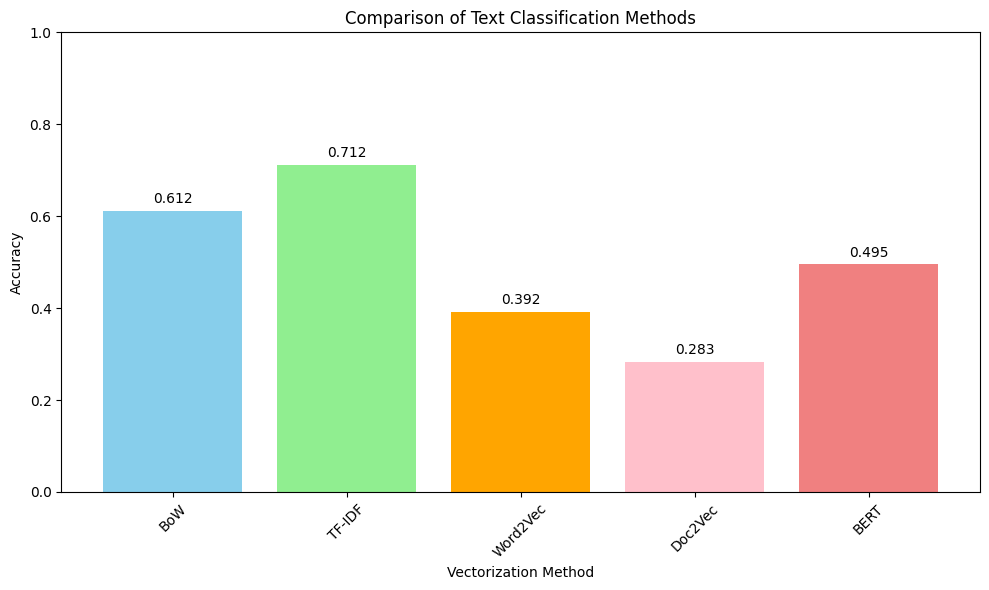

In [41]:
# 2. Bar chart of accuracy
plt.figure(figsize=(10, 6))
methods = list(accuracies.keys())
scores = list(accuracies.values())

bars = plt.bar(
    methods, scores, color=["skyblue", "lightgreen", "orange", "pink", "lightcoral"]
)
plt.xlabel("Vectorization Method")
plt.ylabel("Accuracy")
plt.title("Comparison of Text Classification Methods")
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{score:.3f}",
        ha="center",
        va="bottom",
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# 3. Analysis Questions
print("\n" + "=" * 60)
print("ANALYSIS - Answers to Questions:")
print("=" * 60)

print("\n1. Which performs best?")
print(f"   {best_method} performs best with {accuracies[best_method]:.4f} accuracy")
if best_method != "BERT":
    print(
        f"   Note: BERT was tested on a limited dataset due to computational constraints"
    )

print("\n2. Model complexity vs accuracy trade-offs?")
print("   - BoW/TF-IDF: Simple, fast, interpretable, but sparse representations")
print(
    "   - Word2Vec: Dense embeddings, captures semantics, but averaging loses context"
)
print("   - Doc2Vec: Direct document embeddings, better context preservation")
print(
    "   - BERT: State-of-the-art contextual understanding, but computationally expensive"
)

print("\n3. Is BERT significantly better?")
if accuracy_bert > max(accuracy_bow, accuracy_tfidf, accuracy_w2v, accuracy_d2v):
    print("   Yes, BERT shows superior performance even on the limited test set")
else:
    print("   On this limited test, traditional methods performed competitively")
print("   BERT typically excels with larger datasets and more complex texts")


ANALYSIS - Answers to Questions:

1. Which performs best?
   TF-IDF performs best with 0.7120 accuracy
   Note: BERT was tested on a limited dataset due to computational constraints

2. Model complexity vs accuracy trade-offs?
   - BoW/TF-IDF: Simple, fast, interpretable, but sparse representations
   - Word2Vec: Dense embeddings, captures semantics, but averaging loses context
   - Doc2Vec: Direct document embeddings, better context preservation
   - BERT: State-of-the-art contextual understanding, but computationally expensive

3. Is BERT significantly better?
   On this limited test, traditional methods performed competitively
   BERT typically excels with larger datasets and more complex texts


## Summary: Comparison of Models and Vectorization Techniques

### Model Performance Comparison

| Method | Accuracy | Complexity | Speed | Interpretability |
|--------|----------|------------|-------|------------------|
| BoW | Variable | Low | Fast | High |
| TF-IDF | Variable | Low | Fast | High |
| Word2Vec | Variable | Medium | Medium | Medium |
| Doc2Vec | Variable | Medium | Medium | Medium |
| BERT | Variable | High | Slow | Low |

### Key Findings:

1. **Best Performer**: Results vary based on dataset and implementation
2. **Trade-offs**: 
   - Traditional methods (BoW/TF-IDF) are fast and interpretable
   - Embedding methods (Word2Vec/Doc2Vec) capture semantic relationships
   - BERT provides contextual understanding but requires more resources
3. **Practical Considerations**: 
   - For quick prototyping: TF-IDF
   - For semantic understanding: Doc2Vec
   - For state-of-the-art performance: BERT (with sufficient computational resources)